# 04wk-2: (신경망) – 꺽인그래프의 한계(?), 시벤코정리, MNIST

## 1. Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2. 핵심 내용

## 3. 꺾인 그래프의 한계?

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1, 2, bias = False),    ## 기울기와 절편이 각각 다른 두 개의 직선
#     torch.nn.ReLU(),    ## 두 개의 ReLU 직선(?). ㄴ자로 생긴 선. 양수는 그대로, 음수는 0으로
#     torch.nn.Linear(2, 1),  ## 하나의 꺾인 선분
#     torch.nn.Sigmoid()  ## 하나의 꺾인 곡선
# )

# ## (n, 1) ---l1---> (n, 2) ---a1---> (n, 2) ---l2---> (n, 1) ---a2---> (n, 1)

> 두 개의 직선이 아닌 k개의 직선으로 변환하면?

In [2]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1, k, bias = False),    ## k개의 직선
#     torch.nn.ReLU(),    ## k개의 ReLU 직선
#     torch.nn.Linear(k, 1),  ## 1개의 꺾인 직선
#     torch.nn.Sigmoid()  ## 1개의 꺾인 곡선
# )

> 매트릭스의 차원을 더 크게 잡아주면 꺾는 지점이 더 많아져서 복잡해짐.

### A. Step은 표현 불가능?

`# 예제1` - 일부러 이상하게 만든 취업합격률 곡선

In [ ]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]
sig = torch.nn.Sigmoid()
v = π = sig(u)  ## 이중 할당?
y = torch.bernoulli(v)

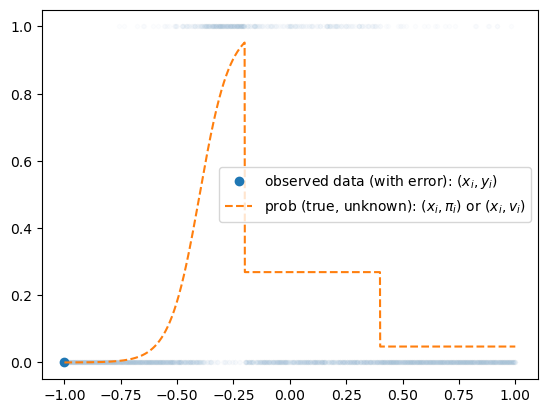

In [6]:
#plt.plot(u,alpha=0.2)
plt.plot(x,y,'.',alpha=0.01,color="C0")
plt.plot(x[0],y[0],'o',color="C0",label=r"observed data (with error): $(x_i,y_i)$")
plt.plot(x,v,'--',label=r"prob (true, unknown): $(x_i,\pi_i)$ or $(x_i,v_i)$",color="C1")
plt.legend()

`-` 대충 계단 영역을 경사가 급하게 만들면 될 것 같음

저 주황색 구조를 어떻게 표현하지? $\to$ 선이 많이 꺽이면되는거아냐?

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

In [9]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()

optimizr = torch.optim.Adam(net.parameters())

## step
for _ in range(5000) :
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

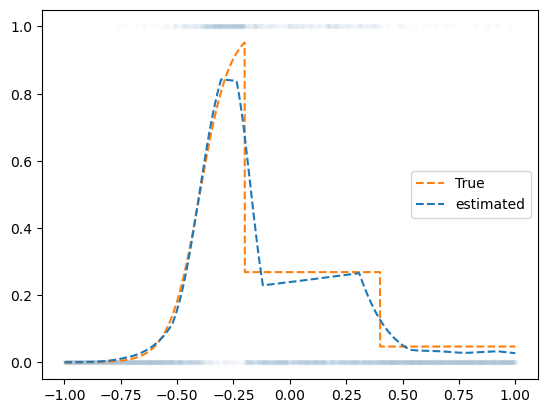

In [11]:
plt.plot(x,y,'.',alpha=0.01,color="C0")
plt.plot(x,v,'--',label="True",color="C1")
plt.plot(x, net(x).data, '--', label = "estimated")
plt.legend()

> 일단 대충 받아들일만은 함...

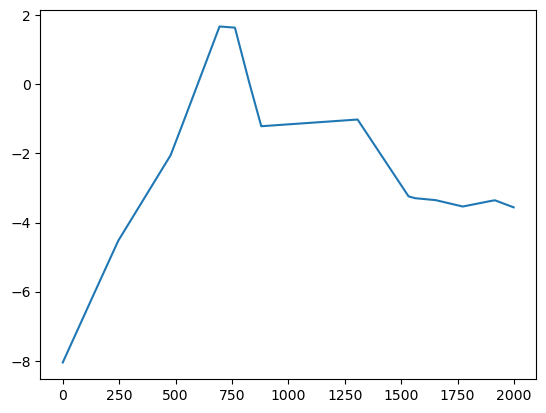

In [ ]:
plt.plot(net[:3](x).data)   ## 시그모이드 먹이기 전 직선

### B. 곡선은 표현 불가능하지 않나?

`# 예제2` – 2024년 수능 미적30번 문제에 나온 곡선

$$y_i = e^{-x_i} \times  |\cos(5x_i)| \times \sin(5x) + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma^2)$$

In [14]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

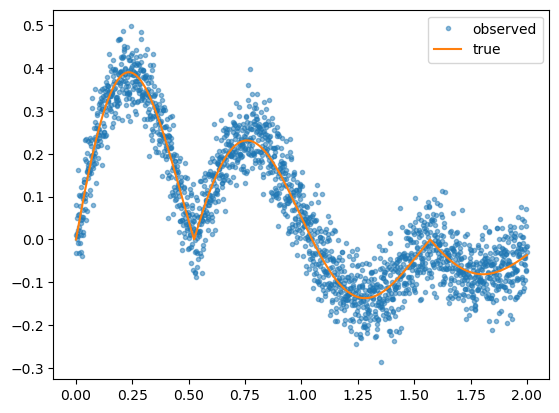

In [18]:
plt.plot(x, y, '.', label = "observed", alpha = 0.5)
plt.plot(x, fx, label = "true")
plt.legend()

In [19]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 1024),   ## bias = True/False는 의미가 없어진 상황
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 1) ## 회귀 문제니까 시그모이드 필요 없징...
)

loss_fn = torch.nn.MSELoss()    ## 회귀와 유사하므로 MSE Loss를 사용 / 애초에 BCE Loss를 쓰기엔 음수값 있음

optimizr = torch.optim.Adam(net.parameters())   ## 그냥 얘가 잘함

##
for epoc in range(1000) :
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

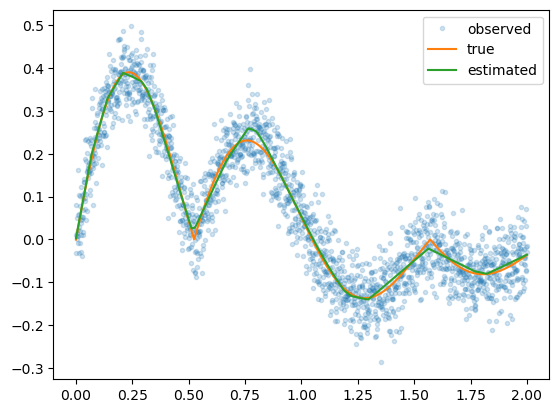

In [22]:
plt.plot(x, y, '.', label = "observed", alpha = 0.2)
plt.plot(x, fx, label = "true")
plt.plot(x, net(x).data, label = "estimated")
plt.legend()

## 4. 시벤코 정리

### A. 시벤코의 정리 소개

> **Universal Approximation Thm Goodfellow, Bengio, and Courville
> (2016)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),   ## ReLU도 상관 없음
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 보렐 가측함수 (Borel measurable function)
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 신경망이 원하는 정확도로 근사시킨다는 의미이다. 예를들면 아래와 같은
> 문제를 해결할 수 있다.
>
> -   ${\bf X}_{n\times 2}$는 토익점수, GPA 이고 ${\bf y}_{n\times 1}$는
>     취업여부일 경우 ${\bf X} \to {\bf y}$인 규칙을 신경망은 항상 찾을
>     수 있다.
> -   ${\bf X}_{n \times p}$는 주택이미지, 지역정보, 주택면적, 주택에
>     대한 설명 이고 ${\bf y}_{n\times 1}$는 주택가격일 경우
>     ${\bf X} \to {\bf y}$인 규칙을 신경망은 항상 찾을 수 있다.
>
> 즉 하나의 은닉층을 가진 신경망의 표현력은 거의 무한대라 볼 수 있다.

### B. 왜 가능한가? : 대충

`-` 데이터

In [26]:
x = torch.linspace(-10, 10, 200).reshape(-1, 1)

`-` 아래와 같은 네트워크를 고려하자.

In [28]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2),
    torch.nn.Sigmoid(), ## 두 개의 곡선
    torch.nn.Linear(2, 1)   ## 두 개의 곡선이 합해진 하나의 곡선
)

l1, a2, l2 = net

`-` 직관 1 : $l_1, l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이 만들 수 있다.

In [30]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [31]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

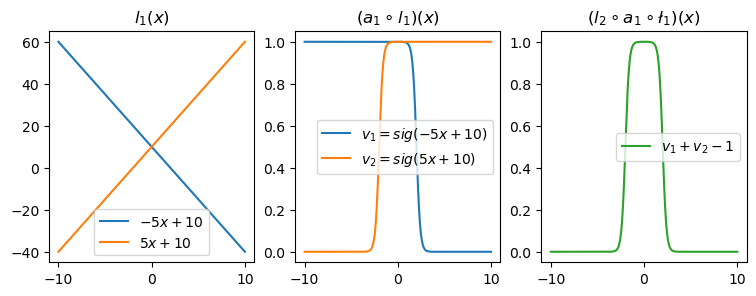

In [32]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x)[:,[0]].data,label=r"$-5x+10$")
ax[0].plot(x,l1(x)[:,[1]].data,label=r"$5x+10$")
ax[0].set_title('$l_1(x)$')
ax[0].legend()
ax[1].plot(x,a1(l1(x))[:,[0]].data,label=r"$v_1=sig(-5x+10)$")
ax[1].plot(x,a1(l1(x))[:,[1]].data,label=r"$v_2=sig(5x+10)$")
ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[1].legend()
ax[2].plot(x,l2(a1(l1(x))).data,color='C2',label=r"$v_1+v_2-1$")
ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')
ax[2].legend()

> 적당히 `weight`와 `bias`를 잘 때려맞추면 이런 모양도 나올 수 있다.

`-` 직관 2 : 계단함수의 모양이 꼭 직관 1과 같을 필요는 없다. 중심과 높이도 조절가능하다.

(-0.1, 2.6)

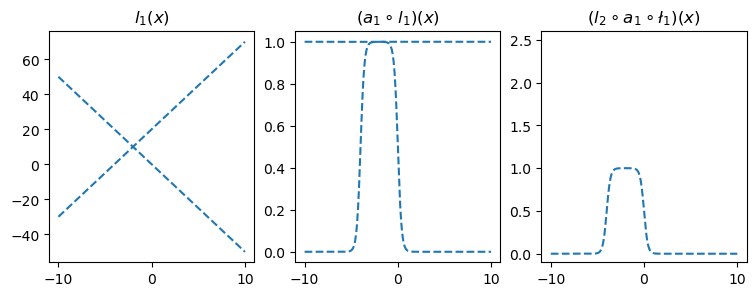

In [ ]:
## 중심을 변경
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

(-0.1, 2.6)

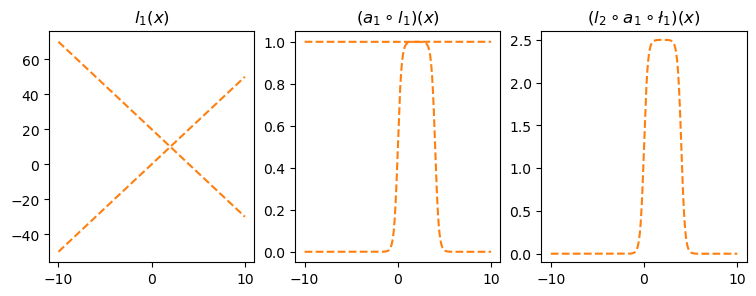

In [ ]:
## 중심과 높이를 변경
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+00.00])
l2.weight.data = torch.tensor([[2.50,2.50]])    ## 두 번쨰 선형변환에서 스케일을 변경
l2.bias.data = torch.tensor([-2.50])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

`-` 직관3: `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [35]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [36]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

Text(0.5, 1.0, '$(l_2 \\circ a_1 \\circ l_1)(x)$')

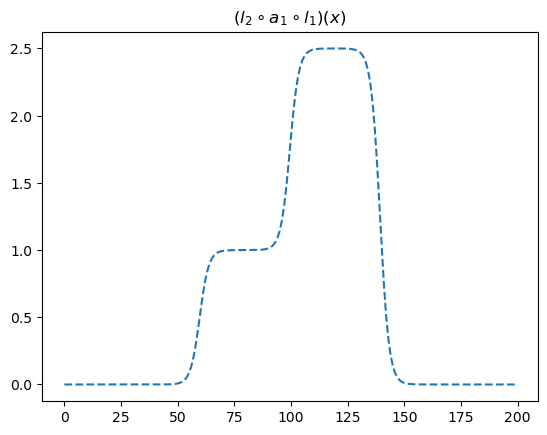

In [37]:
plt.plot(l2(a1(l1(x))).data,'--')
plt.title(r"$(l_2 \circ a_1 \circ l_1)(x)$")

> 0을 제외한 서로 다른 계단의 높이는 2개가 된다. 대충 2단계-계단함수라고 하자.

`-` **정리1** : 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은 '1단계-계단함수' $h$를 만들 수 있다.

In [ ]:
h = lambda x : torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
## 대충 계수 절대값 왕창 올려서 경사 급하게 만들어버림. 중심은 -0.5와 0.5로 함
## lambda x : torch.sigmoid(200*(x+0.5)) - torch.sigmoid(200*(x-0.5)) ## 이거랑 동일

Text(0.5, 1.0, '$h(x)$')

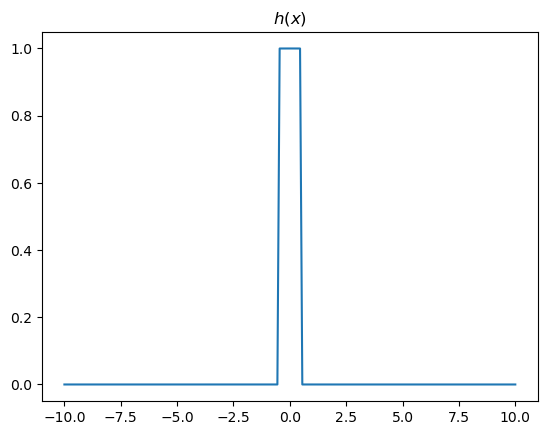

In [39]:
plt.plot(x, h(x))
plt.title("$h(x)$")

`-` 정리2: 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 “m단계-계단함수”와 같은
형태의 네트워크는 아래와 같이 $m$개의 은닉노드를 써서 항상 표현할 수
있다.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

> $h$를 두 개의 시그모이드로 만든 거니까...

`-` 직관4: 그런데 어떠한 함수형태라도 구불구불한 “m단계-계단함수”로 다
근사할 수 있지 않나?

### C. $h$의 위력

`-` 소망 : 아래와 같이 `net`을 설계해서 그 위력을 체감해보고 싶음...

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(1, ??),
    torch.nn.H(),
    torch.nn.Linear(??, 1)
)
```

`-` $h(x)$를 생성하는 클래스를 만들어보자.

In [ ]:
class H(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__()  ## 슈퍼 클래스 torch.nn.Module의 __init__을 그대로 가져와서 사용
    def forward(self, u):   ## 메소드 overriding
        h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
        v = h(u)
        return v # activation 의 출력

In [46]:
my_h = H()

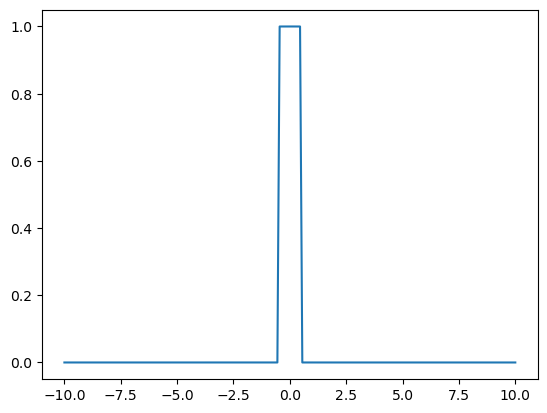

In [49]:
plt.plot(x, my_h(x))

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` $h$의 위력을 체감해보자.

`# 예제1` – 스펙의 역설

In [50]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2025/main/posts/ironyofspec.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

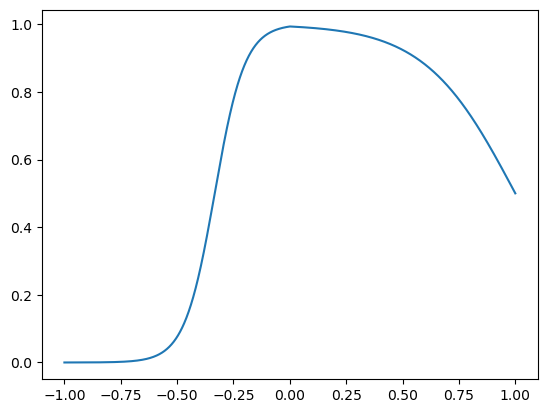

In [51]:
plt.plot(x, prob)

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2024),
    H(),
    torch.nn.Linear(2024, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

##
for epoc in range(200) :
    yhat = net(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

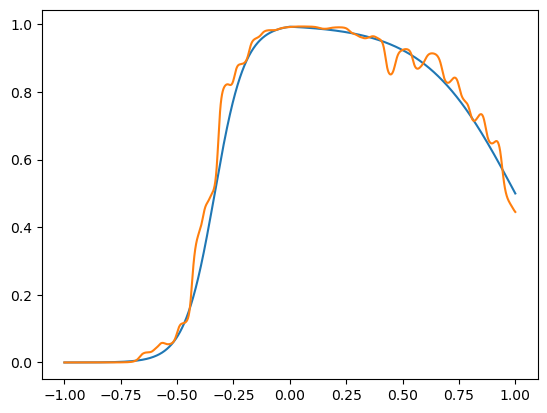

In [56]:
plt.plot(x, prob)
plt.plot(x, net(x).data)

> 고작 1단계 계단함수만으로 어느정도 잘 따라가는 모델을 구축할 수 있음.
>
> 그냥 모델링 유기하고 `H`만 사용해도 됨

`# 예제2` - 수능 곡선

In [57]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

In [58]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2024),
    H(),
    torch.nn.Linear(2024, 1)
)

loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

## 
for epoc in range(200) :
    yhat = net(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

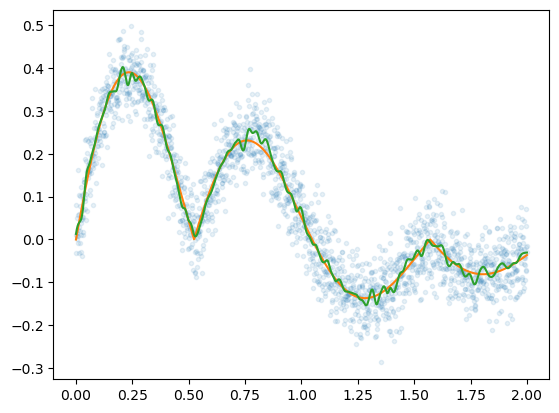

In [59]:
plt.plot(x, y, '.', alpha = 0.1)
plt.plot(x, fx)
plt.plot(x, net(x).data)

> 구불구불한데, 아무튼 맞춤. ㅇㅇ

activate function이 시그모이드든, ReLU든, 일단 되기만 하면 충분함.

### D. 의문점

`-` 이 수업을 잘 이해한 사람: 그냥 활성화함수를 $h$로 쓰면 끝 아니야?
뭐하러 relu 를 쓰는거지?

`-` 딥러닝을 좀 공부해본사람1: 왜 딥러닝이 2010년이 지나서야 떳지?
1989년에 세상의 모든 문제가 풀려야 하는것 아닌가?

`-` 딥러닝을 좀 공부해본사람2: 하나의 은닉층을 가진 네크워크는 잘 안쓰지
않나? 은닉층이 깊을수록 좋다고 들었는데?

`-` 약간의 의구심이 있지만 아무튼 우리는 아래의 무기를 가진 꼴이 되었다.

> **우리의 무기**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크로,
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 보렐 가측
> 함수 $f$ 을 원하는 정확도로 “근사”시킬 수 있다.

## 5. MNIST 해결

### A. 예비학습 - `plt.imshow()`

`-` `plt.imshow(...)`에서 `...`의 `shape`가 (??, ??)이면 흑백이미지를 출력 -> K

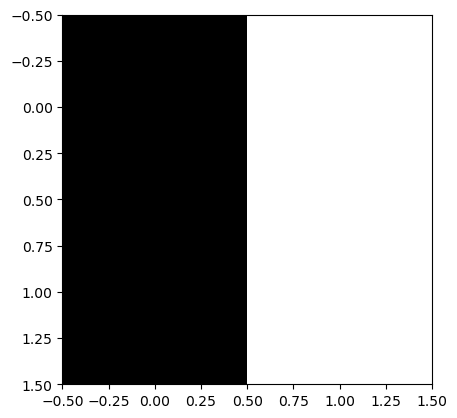

In [ ]:
plt.imshow([[0, 255],
            [0, 255]], cmap = 'gray')

`-` `plt.imshow(...)`에서 `...`의 shape이 (??, ??, 3)이면 컬러 이미지를 출력 -> RGB

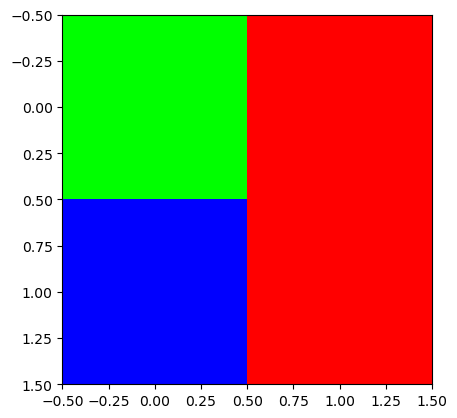

In [ ]:
r = [[0,255],
     [0,255]]
g = [[255,0],
     [0,  0]]
b = [[0,  0],
     [255,0]]

img = np.stack([r,g,b],axis=2) ## (2, 2, 3) tensor
plt.imshow(img)

`-` `plt.imshow(...)`에서 텐서의 자료형이 `int`인지, `float`인지에 따라서 인식이 다름

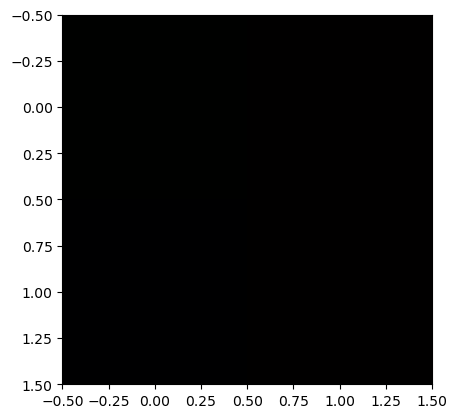

In [64]:
r = [[0,1],
     [0,1]]
g = [[1,0],
     [0,0]]
b = [[0,0],
     [1,0]]

plt.imshow(np.stack([r,g,b],axis=2))

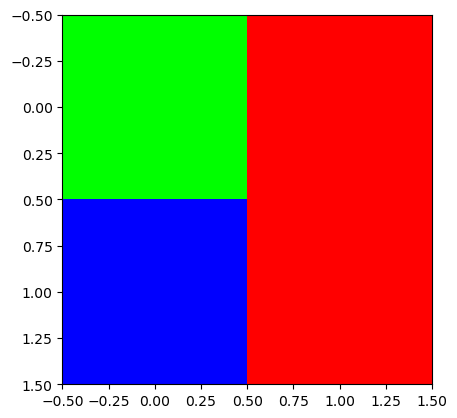

In [ ]:
r = [[0,1.0],
     [0,1]]
g = [[1,0],
     [0,0]]
b = [[0,0],
     [1,0]]

plt.imshow(np.stack([r,g,b],axis=2))    ## 전부 float으로 포매팅

### B. 데이터

`-` 데이터 정리 코드

In [67]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X3 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==3])
X7 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==7])
X = torch.concat([X3,X7],axis=0)
y = torch.tensor([0.0]*len(X3) + [1.0]*len(X7))

100.0%
100.0%
100.0%
100.0%


In [ ]:
train_dataset[0] ## 대충 이미지랑 그에 해당되는 숫자
test_dataset[0] ## 이미지만

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [ ]:
X.shape, y.shape

(torch.Size([12396, 1, 28, 28]), torch.Size([12396]))

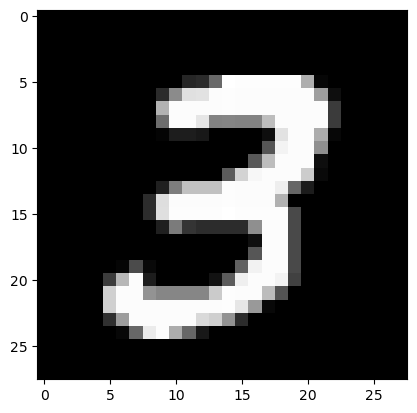

In [72]:
plt.imshow(X[0][0], cmap = 'gray')

> 대충 12396개의 이미지, K 채널, 28×28 픽셀

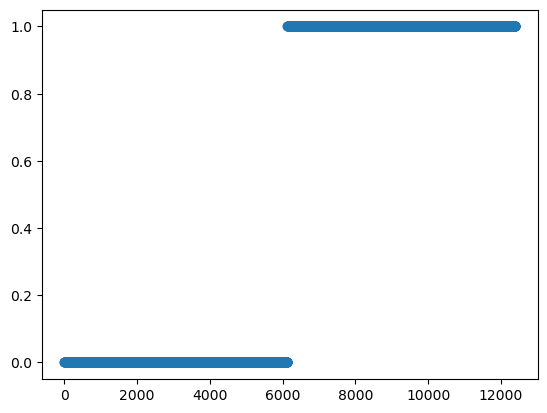

In [82]:
plt.plot(y,'o')

-   “y=0.0” 은 숫자3을 의미함, “y=1.0” 은 숫자7을 의미함
-   숫자3은 6131개, 숫자7은 6265개 있음

`-` 우리는 ${\bf X}: (n,1,28,28)$ 에서 ${\bf y}: (n,1)$으로 가는 맵핑을
배우고 싶음. $\to$ 이런건 배운적이 없는데?.. $\to$ 그렇다면
${\bf X}:(n,784) \to {\bf y}:(n,1)$ 으로 가는 맵핑을 학습하자.

> 대충 언더라잉이 뭐든지, 일단 시벤코 정리에 의해 맞출 수 있음

In [88]:
X = torch.stack([xi.reshape(-1) for xi in X])   ## X는 이미지만 있는 (n, 1, 28, 28) 텐서, xi는 (1, 28, 28)
y = y.reshape(-1, 1)

In [89]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
# X = torch.concat([X3,X7],axis=0).reshape(-1,28*28).float()
# X.shape, y.shape

### C. 학습

In [103]:
net = torch.nn.Sequential(
    torch.nn.Linear(784, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid()  ## 이진 분류 문제이므로 시그모이드
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

##
for epoc in range(2000) :
    ## 1
    yhat = net(X)
    ## 2
    loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

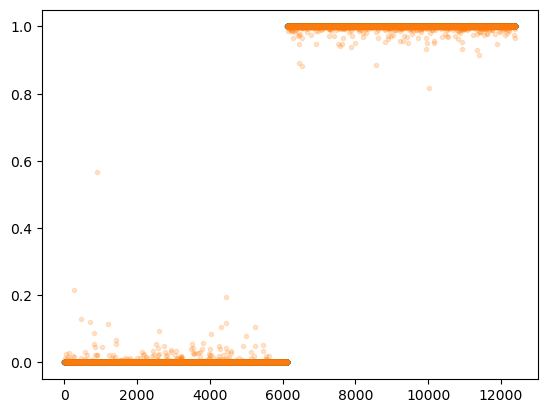

In [104]:
plt.plot(y, '.')
plt.plot(net(X).data, '.', alpha = 0.2)

In [105]:
torch.mean((y == (net(X).data >= 0.5)*1.0)*1.0)

tensor(0.9999)

> epoc을 존나 늘리니까 개잘함. 하나 빼고 다맞췄네